# Validation Dataset ESS generation and deconvolution

This notebook was used to create the office's responses to Exponential Sine Sweeps. An ESS is created, with 1% off the beginning and the end tapered. It is then made to play after 4 seconds 10 times in a row separated by 1 second. It can be played directly from the notebook or as a _.wav_ file.

Once played, recording of the sweeps was performed independantely on the HoloLens2 using a ROS script. (See AV-SUARA repository).

We then create a time-inversed and exponentially decreasing ESS, which can be convolved with any version of the original ESS to create a dirac. Any echoes recorded by a microphone will appear as diracs, and so we've obtained our Room Impulse Response.

## ESS

### ESS Implementation taken from [mattberjon](https://gist.github.com/mattberjon/b0886a1c8a9bd512e84942f088a6410f).

This code is equivalent (- operation inaccuracies >:( ...) to this [much simpler implementation I found online](https://dsp.stackexchange.com/questions/41696/calculating-the-inverse-filter-for-the-exponential-sine-sweep-method "Simple implementation on stackexchange"). This is the implementation I used to create the sweeps I used to record the RIRs for my validation dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

""" Corresponds to an exponential sine sweep as described by Farina in his paper 
Simultaneous measurement of impulse response and distortion with a swept-sine technique, 2000.
"""

# Parameters
amp = 0.5 
f1 = 100.
f2 = 20000.
N = 17. 
fs = 48000.

# Generate sweep
T = (2**N) / fs # 2.73066 Duration of sweep.
w1 = 2 * np.pi * f1
w2 = 2 * np.pi * f2
K = T * w1 / np.log(w2 / w1)
L = T / np.log(w2 / w1)
t = np.linspace(0, T - 1 / fs, int(fs * T))
sweep = amp * np.sin(K * (np.exp(t / L) - 1))

### Taper ESS

In [2]:
# Define the percentage of the signal to taper (e.g., 1% of the signal length)
taper_percent = 0.01

# Calculate the length of the taper window
taper_length = int(len(sweep) * taper_percent / 2)

# Create a short Hanning window for tapering
short_window = np.hanning(2 * taper_length)

# Apply the taper to the beginning and end of the signal
tapered_sweep = np.copy(sweep)
tapered_sweep[:taper_length] *= short_window[:taper_length]
tapered_sweep[-taper_length:] *= short_window[-taper_length:]

tapered_sweep, taper_length  # Display the tapered signal and the length of the tapering window

(array([ 0.00000000e+00,  3.76985485e-08,  3.01566905e-07, ...,
        -7.52675869e-06,  2.71997639e-06, -0.00000000e+00]),
 655)

### Show ESS

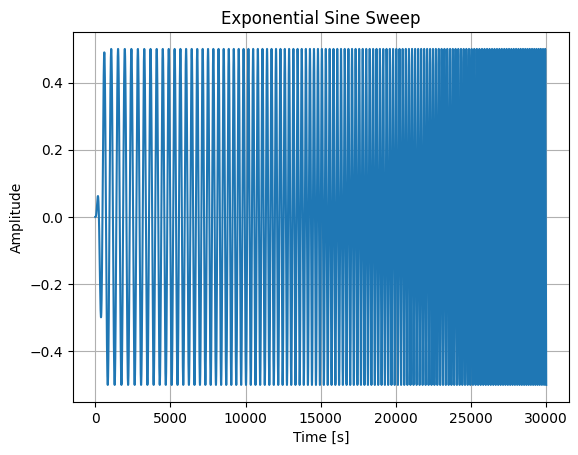

In [3]:
from functools import partial
plt.figure()
plt.plot(tapered_sweep[:30000])
plt.title('Exponential Sine Sweep')
plt.xlabel('Time [s]')
# plt.xscale('log')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

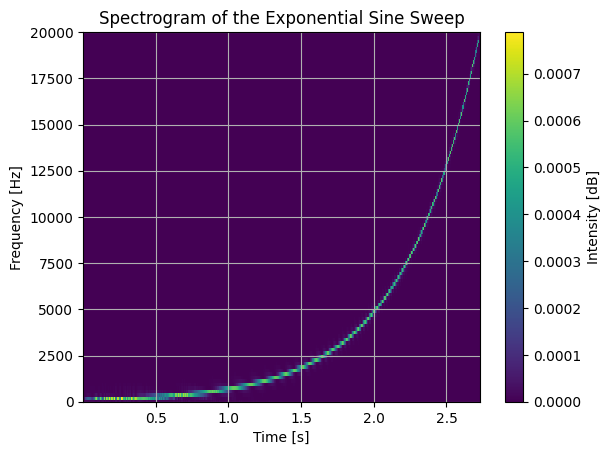

In [13]:
plt.figure()
f_sweep, t_sweep, Sxx_sweep = signal.spectrogram(tapered_sweep, fs)
plt.pcolormesh(t_sweep, f_sweep, Sxx_sweep)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram of the Exponential Sine Sweep')
# plt.yscale('log')
plt.ylim([0, 20000])
plt.colorbar(label='Intensity [dB]')
plt.grid(True)
plt.show()


## 10x ESS, playback

In [5]:
sweep_times_x = tapered_sweep
fs_int=int(fs)
one_second_of_silence=np.zeros(fs_int*2)
# Add 4 seconds of silence
# for i in range(4):
#     sweep_times_x = np.concatenate((one_second_of_silence,sweep_times_x))
# Add 5 seconds xtra sweeps
for i in range(4):
    sweep_times_x = np.concatenate((sweep_times_x,one_second_of_silence))
    sweep_times_x = np.concatenate((sweep_times_x,tapered_sweep))
# 1 xtra second of silence
sweep_times_x = np.concatenate((sweep_times_x,one_second_of_silence))
# xtra zeros
sweep_times_x = np.concatenate((np.zeros(20),sweep_times_x,np.zeros(20)))

### Write ESS

Write sweep as wav file.

In [6]:
from scipy.io.wavfile import write

to_save = sweep_times_x

# Scale the sweep to 16-bit integers
sweep_int = np.int16(to_save / np.max(np.abs(to_save)) * 32767)

# Save the sweep as a WAV file
write('ESS_x5_2second_pause.wav', int(fs), sweep_int)

Play sweep.

In [17]:
from IPython.display import Audio

# Generate the audio player for the sweep signal
# Audio(sweep, rate=fs)
Audio(sweep_int, rate=fs)

## Inverse ESS

In [17]:
# Inverse filter
Inverse_filter_exp_scaling = np.exp(t / L)
inverse_tapered_sweep = tapered_sweep[::-1]/Inverse_filter_exp_scaling

## Example ESS deconvolution

In [18]:
import scipy.signal as sig
ir = sig.fftconvolve(tapered_sweep, inverse_tapered_sweep, mode='same')

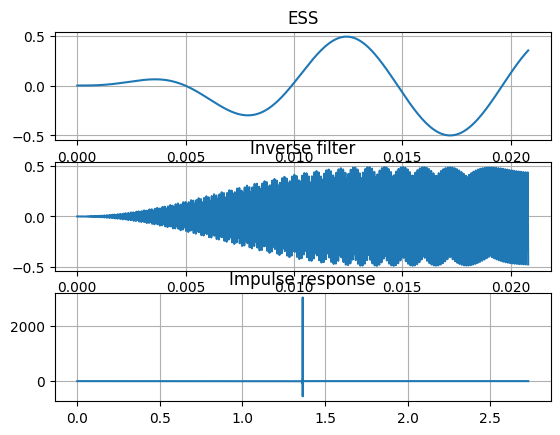

In [21]:
plt.figure()
plt.subplot(3,1,1)
plt.grid()
plt.plot(t[:1000], tapered_sweep[:1000])
plt.title('ESS')
plt.subplot(3,1,2)
plt.grid()
plt.plot(t[:1000], inverse_tapered_sweep[:1000])
plt.title('Inverse filter')
plt.subplot(3,1,3)
plt.grid()
plt.plot(t, ir)
plt.title('Impulse response')
plt.show()

## A perfect 10x ESS estimation

In [24]:
ir = sig.fftconvolve(sweep_times_10, inverse_tapered_sweep, mode='same')

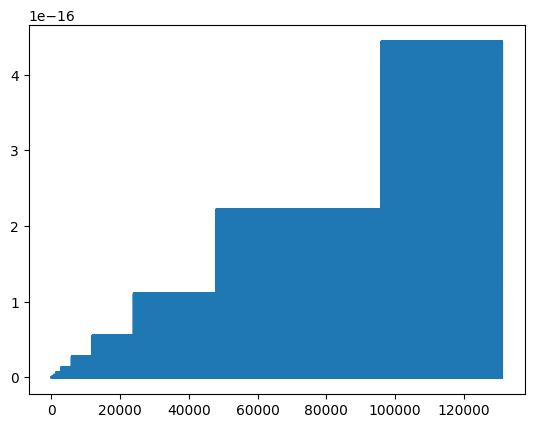

In [30]:
# This is the error from those divisions from that weird implementation >:(
t_guess=np.arange(len(t))/fs
plt.plot(np.sqrt((t-t_guess)**2))
plt.show()


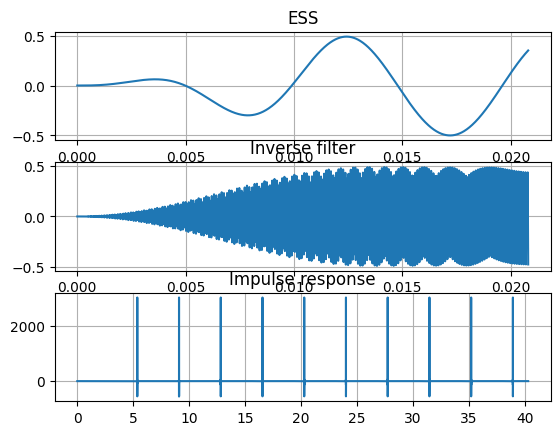

In [31]:
plt.figure()
plt.subplot(3,1,1)
plt.grid()
plt.plot(t[:1000], tapered_sweep[:1000])
plt.title('ESS')
plt.subplot(3,1,2)
plt.grid()
plt.plot(t[:1000], inverse_tapered_sweep[:1000])
plt.title('Inverse filter')
plt.subplot(3,1,3)
plt.grid()
plt.plot(np.arange(len(ir))/fs, ir)
plt.title('Impulse response')
plt.show()